In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

Mesh has 476 nodes


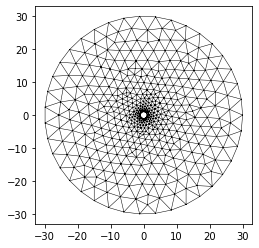

In [40]:
# defining the mesh is easy with pygmsh

import pygmsh

# different radius for the wellbore r and the domain R
r = 1
R = 30 * r

with pygmsh.geo.Geometry() as geom:

    # we need the outer and inner circles to be defined as curved loops rather than surfaces
    # the make_surface=False keyword is needed
    outer = geom.add_circle([0, 0], R, mesh_size=5, make_surface=False)
    inner = geom.add_circle([0, 0], r, mesh_size=0.5, make_surface=False)

    # we can pass a list of holes to the add_plane_surface function
    surface = geom.add_plane_surface(outer.curve_loop, holes=[inner])
    out = geom.generate_mesh()

mesh = Mesher.Mesh(out)

mesh.plot()
#plt.scatter(*mesh.nodes.T, c='tab:blue', s=10, zorder=10, ec='k')
print(f'Mesh has {mesh.nn} nodes')


(-1.5, 1.5)

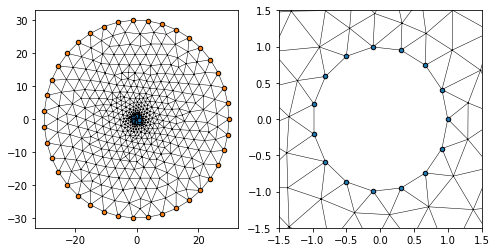

In [41]:
# we need to select the nodes for the two different boundaries to set the proper boundary conditions
borehole = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - r) < 1e-3)
outer = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - R) < 1e-3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    mesh.plot(ax=axs[i])

    axs[i].scatter(*mesh.nodes[borehole].T, s=20, zorder=10, ec='k')
    axs[i].scatter(*mesh.nodes[outer].T, s=20, zorder=10, ec='k')

axs[1].set_xlim(-1.5 * r, 1.5 * r)
axs[1].set_ylim(-1.5 * r, 1.5 * r)


In [42]:
# now we want to compute the force vector
Q = 1
circumference = 2*np.pi*r
q = Q/circumference

arc_length = circumference/len(borehole)
f = np.zeros(mesh.nn)
f[borehole] = q * arc_length * r

In [43]:
# we now define the conductivity matrices
C = Matrix.assemble_conductivity_matrix(mesh, 1)
M = Matrix.assemble_mass_matrix(mesh, 1)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [44]:
# we can now solve the system of equations at every time step
theta = 0.8
eye = np.eye(mesh.nn)

nt = 2000
tmax = 500
t = np.linspace(0, tmax, nt)
dt = t[1] - t[0]
pressure = np.zeros((nt, mesh.nn))

D =  M + theta * dt * C

for i in range(len(t) - 1):
    print(f'\riteration {i + 1} out of {len(t)}', end='')
    right = dt * (f - C*pressure[i])
    dp = linalg.spsolve(D, right)
    pressure[i + 1] = pressure[i] + dp


iteration 1999 out of 2000

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x15a5574a5e0>)

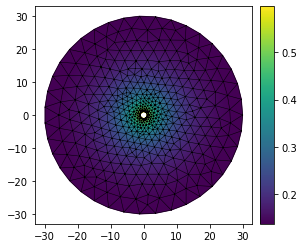

In [116]:
mesh.plot(pressure[-1])

[ 1.        10.0407555 30.       ]


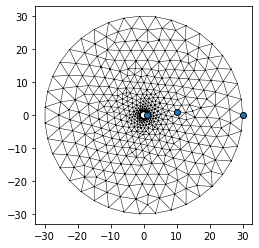

In [234]:
# we want to look at the temporal evoluotion of the pressure for a few given points
radiuses = [r, R/3, R]

# since the mesh is not exactly defined at those intervals, we want to take only the closest points
indices = np.zeros(len(radiuses), dtype=int)
for i, radi in enumerate(radiuses):
    distance = np.abs(np.linalg.norm(mesh.nodes, axis=1) - radi)
    indices[i] = distance.argmin()

# we can check what that looks like
points = mesh.nodes[indices]
mesh.plot()
plt.scatter(*points.T, zorder=10, ec='k')
print(np.linalg.norm(points, axis=1))

In [235]:
# we can try some analytical solutions
from scipy.special import exp1

def line_source(radi, t, Q, k=1, S=1):
    c = k/S
    r2 = radi * radi
    return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))

def cylindrical_source(radi, wellbore_radi, reservoir_radi, t, Q, k=1, S=1):
    Rd = reservoir_radi/wellbore_radi
    rd = radi/wellbore_radi
    c = k/S
    td = t / (c * wellbore_radi * wellbore_radi)

    A = 2 / ((Rd ** 2) - 1) * ((rd ** 2) / 4 + td)
    B = (Rd ** 2) * np.log(rd) / ((Rd ** 2) - 1)
    C_up = (3 * Rd ** 4) - 4 * np.log(Rd) * (Rd ** 4) - 2 * (Rd ** 2) - 1
    C_down = 4 * ((Rd ** 2) - 1)**2

    return Q/(2 * np.pi * k) * (A - B - C_up / C_down)


#plt.plot(t, cylindrical_source(1, r, R, t, Q))



<ipython-input-235-b7e6fc5c5156>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
<ipython-input-235-b7e6fc5c5156>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
<ipython-input-235-b7e6fc5c5156>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))


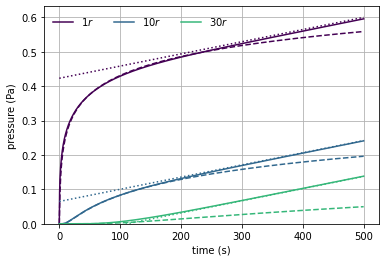

In [243]:
labels = [f'{radi/r:.0f}$r$' for radi in radiuses]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/len(labels)) for i in range(len(labels))]

# our pressure array has shape (n_timesteps, n_nodes)
for i, p in enumerate(pressure[:, indices].T):
    plt.plot(t, p, label=labels[i], color=colors[i])
    plt.plot(t, line_source(radiuses[i], t, Q), c=colors[i], ls='dashed')
    plt.plot(t, cylindrical_source(radiuses[i], r, R, t, Q), c=colors[i], ls='dotted')

plt.legend(ncol=3, loc='upper left', frameon=False)
plt.xlabel('time (s)')
plt.ylabel('pressure (Pa)')
plt.ylim(0, None)
plt.grid()